### Libraries to be used

In [1]:
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
from transformers import pipeline
from __future__ import unicode_literals
import spacy,en_core_web_sm
from spacy.lang.en import English
from spacy.matcher import Matcher
import textacy
import string
from wordcloud import WordCloud, STOPWORDS 
import numpy as np
import nltk
import locationtagger
from difflib import SequenceMatcher

C:\Users\Asus\anaconda3\envs\pyspark\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Class that contein all methods to answer the question

In [2]:
class MlSkillsOne:
    
    def __init__(self):
        pass
        self.all_records_raw_df = self.read_data_of_individual_topics()
        self.target_phrase = "Jeu de Paume is an excellent art gallery in Paris"        
        self.all_records_cleaned_df = self.data_cleaner()

    def read_data_of_individual_topics(self):

        path = 'individualTopics_27-01-22/'
        all_records = []

        for fname in glob.glob(path + '*.pickle'):
            obj = pd.read_pickle(fname)
            record = [obj['id'],obj['name'],obj['audience_size'],
                      obj['country'],obj['topic']]
            all_records = all_records + [record]
        
        all_records_df = pd.DataFrame.from_records(all_records)
        all_records_df.columns = ['id','name','audience_size','country','topic']
        
        return all_records_df
    
    def number_of_verb(self, string):
        verbs = []
        pattern = [{'POS': 'VERB', 'OP': '?'},\
               {'POS': 'VERB', 'OP': '+'}]
        doc = textacy.make_spacy_doc(string, lang='en_core_web_sm')
        lists = textacy.extract.matches.token_matches(doc, [pattern])
        for list in lists:
            verbs.append(list.text)
            
        return len(verbs)
    
    def number_of_letters(self, string):
        return len([i for i in string if i.isalpha()])
    
    def get_location(self, string):
        place_entity = locationtagger.find_locations(text = string)
        countries = place_entity.countries
        regions = place_entity.regions
        cities = place_entity.cities
        X = countries + regions + cities
        return X

    def similarity(self, row):
        return SequenceMatcher(None, row, self.target_phrase).ratio()
    
    def data_cleaner(self):

        self.all_records_raw_df["name_cleaned"] = self.all_records_raw_df.name\
            .apply(lambda row: row.translate(str.maketrans('', '', string.punctuation)))
        
        self.all_records_raw_df["number_of_verb"] = self.all_records_raw_df.name_cleaned\
            .apply(lambda row: self.number_of_verb(row))
        
        self.all_records_raw_df["number_words"] = self.all_records_raw_df.name_cleaned\
            .apply(lambda row: len(row.split()))
            
        self.all_records_raw_df["number_letters"] = self.all_records_raw_df.name_cleaned\
            .apply(lambda row: self.number_of_letters(row))
        
        self.all_records_raw_df["number_letters_words_verbs"] = self.all_records_raw_df.number_letters.\
            apply(lambda row: [row]) + self.all_records_raw_df.number_words.apply(lambda row: [row]) + \
            self.all_records_raw_df.number_of_verb.apply(lambda row: [row])
         
        self.all_records_raw_df["name_entity"] =  self.all_records_raw_df.name_cleaned\
            .apply(lambda row: self.get_location(row))  
         
        self.all_records_raw_df["similarity"] =  self.all_records_raw_df.name_cleaned\
            .apply(lambda row: self.similarity(row))
        
        self.all_records_raw_df["target_phrase"] = self.target_phrase
        
        return self.all_records_raw_df
        
    def word_cloud(self):
        string = self.all_records_raw_df.name_cleaned
        comment_words = ''
        stopwords = set(STOPWORDS)
        for val in string:

            # typecaste each val to string
            val = str(val)

            # split the value
            tokens = val.split()

            # Converts each token into lowercase
            for i in range(len(tokens)):
                tokens[i] = tokens[i].lower()

            comment_words += " ".join(tokens)+" "

        wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

        # plot the WordCloud image                      
        plt.figure(figsize = (8, 8), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)

        plt.show()   

In [3]:
skills = MlSkillsOne()

# EXERCISE 1

### The list "the_topics" contains a list of short sentences in different languages. Stating from this list, complete the following tasks:

1.1) Create a list of lists A=[[n_letters_1, n_words_1, n_verbs_1],[n_letters_2, n_words_2, n_verbs_2], ...,
[n_letters_k, n_words_k, n_verbs_k] ], where:

-n_letters_i: Is the number of letters (excluding spaces and punctuation symbols) in sentence i

-n_words_i: Is the number of words in  sentence i

-n_verbs_i: Is the number of verbs in  sentence i (for sentences in languages other than English, this value is not relevant (you may either set it to zero or leave an incorrect value). 

In [4]:
skills.all_records_cleaned_df[["name_cleaned", "number_letters_words_verbs"]].head()

,name_cleaned,number_letters_words_verbs
0,Te Amo,"[5, 2, 0]"
1,500 Days of Summer,"[12, 4, 0]"
2,1 LIVE,"[4, 2, 0]"
3,11 Internet,"[8, 2, 0]"
4,1800Flowers,"[7, 1, 0]"


#### 1.2) Visualize as a figure the wordcloud (https://en.wikipedia.org/wiki/Tag_cloud) of the corpus comprising all the sentences in "the_topics".

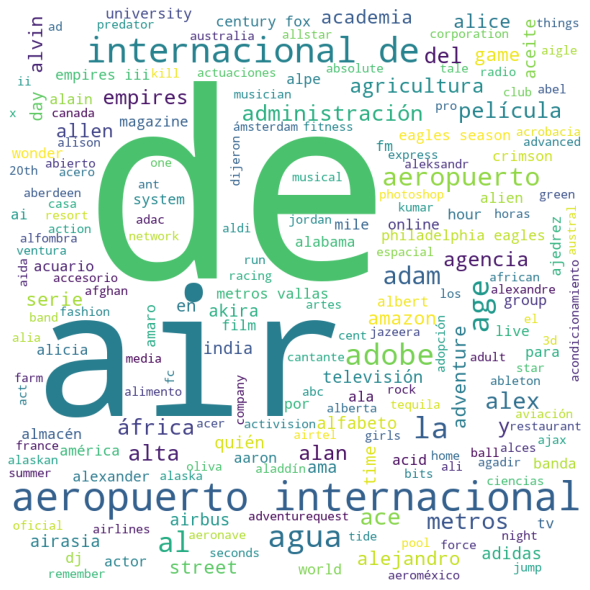

In [5]:
skills.word_cloud()

#### 1.3) A named entity is a “real-world object” that’s assigned a name - for example, a person, a country, a product or a book-. Create a new list with all sentences in "the_topics" that contain at least one geopolitical entity (eg., countries, cities, states)

In [6]:
skills.all_records_raw_df.name_entity [skills.all_records_raw_df.name_entity.astype(bool)]

17               [Bathurst]
34                 [France]
35                [Tequila]
39                  [Broke]
58                 [Street]
               ...         
986                 [Norte]
987            [Occidental]
988    [Oriental, Oriental]
991                  [Ruiz]
999                 [Piece]
Name: name_entity, Length: 231, dtype: object

#### 1.4) Compute the semantic similarity of each topics to the following sentence "Jeu de Paume is an excellent art gallery in Paris".  Rank the sentences the computed values of the semantic similarity. The top ranked sentence from the_topics is the one with closest similarity to the given sentence. You may use any method or algorithm to compute this ranking. The output of this exercise could be the index of each word in the ranking, or a new list "ranked_topics".

In [7]:
skills.all_records_raw_df[["name_cleaned","target_phrase","similarity"]].head()

,name_cleaned,target_phrase,similarity
0,Te Amo,Jeu de Paume is an excellent art gallery in Paris,0.109091
1,500 Days of Summer,Jeu de Paume is an excellent art gallery in Paris,0.208955
2,1 LIVE,Jeu de Paume is an excellent art gallery in Paris,0.036364
3,11 Internet,Jeu de Paume is an excellent art gallery in Paris,0.200000
4,1800Flowers,Jeu de Paume is an excellent art gallery in Paris,0.133333


#### Por limitacion con la capacidad de procesamiento, la data utilizada para la ejecucion de este codigo es de solo 1000 archivos tomados de la data original.